In [33]:
# Importing required libraries

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing
import librosa
import IPython.display as ipd

# Feature scaling
import sklearn.preprocessing

# File system operations
import os

## **Importing and playing a first audio file**

In [34]:
audio_path = '../data/raw/genres_original/reggae/reggae.00000.wav'
# sr=None to preserve the native sampling rate
array, sampling_rate = librosa.load(audio_path, sr=None)

print(f'x: {array.shape}', f'sample rate: {sampling_rate}', sep='\n')

x: (661794,)
sample rate: 22050


This returns an audio time series as a numpy array with a default **sampling rate(sr)** of 22KHZ mono. The sampling rate (also called sampling frequency) is the *number of samples taken in one second* and is measured in hertz (Hz).

The audible frequencies in human speech are below 8 kHz and therefore sampling speech at 16 kHz is sufficient (Nyquist). Using a higher sampling rate will not capture more information and merely leads to an increase in the computational cost of processing such files.

In [35]:
array, sampling_rate = librosa.load(audio_path, sr=16000)

print(f'x: {array.shape}', f'sample rate: {sampling_rate}', sep='\n')

x: (480214,)
sample rate: 16000


To make it easier to interpret the visualizations and other characteristics of the audio, we will use only the a first part of the original audio.

In [36]:
array = array[:100000]

The **amplitude of a sound** describes the *sound pressure level at any given instant* and is measured in decibels (dB). In digital audio, each audio sample records the amplitude of the audio wave at a point in time. 

Also, the **bit depth** of the sample determines with how much *precision* this amplitude value can be described. The higher the bit depth, the more faithfully the digital representation approximates the original continuous sound wave.

In [37]:
print('Amplitude sample:', array[:5])

print('bit depth:', array.dtype)

Amplitude sample: [0.00518333 0.01790155 0.07761538 0.12327619 0.07922523]
bit depth: float32


Each is a binary term, representing the number of possible steps to which the amplitude value can be quantized when it’s converted from continuous to discrete. For the given 32bit depth we can achieve an incredible 4,294,967,296 steps.

Because quantizing involves rounding off the continuous value to a discrete value, the *sampling process introduces noise*. The *higher the bit depth, the smaller this quantization noise*. 

In practice, the quantization noise of 16-bit audio is already small enough to be inaudible, and using higher bit depths is generally not necessary.

In [38]:
# To display and listen the audio file we use the ipd.Audio widget
ipd.Audio(audio_path)

## **Audio Visualization**

Just as with continuous audio signals, the amplitude of digital audio is typically expressed in decibels (dB). Since human hearing is logarithmic in nature — our ears are more sensitive to small fluctuations in quiet sounds than in loud sounds — the loudness of a sound is easier to interpret if the amplitudes are in decibels, which are also logarithmic.

The decibel scale for real-world audio starts at 0 dB, which represents the quietest possible sound humans can hear, and louder sounds have larger values. However, for digital audio signals, 0 dB is the loudest possible amplitude, while all other amplitudes are negative. As a quick rule of thumb: every -6 dB is a halving of the amplitude, and anything below -60 dB is generally inaudible unless you really crank up the volume.

### **Waveform**

A **Waveform** plots the sample values over time and illustrates the changes in the sound’s amplitude. This is also known as the *time domain representation of sound*.  It's commonly used to find similarities or differences between audio signals.

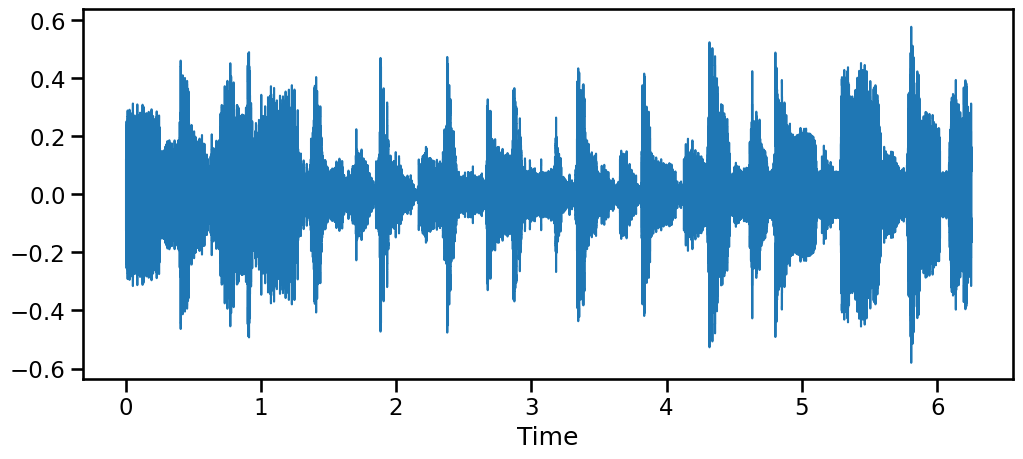

In [39]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

This plots the **amplitude** of the signal on the **y-axis** and **time** along the **x-axis**. In other words, each point corresponds to a single sample value that was taken when this sound was sampled.

Also note that librosa returns the audio as floating-point values already, and that the amplitude values are indeed within the [-1.0, 1.0] range.

### **Frequency Spectrum**

The **frequency spectrum** of an audio signal is a visual representation of the *frequencies that make up the sound*. It shows the amplitude (or intensity) of each frequency component present in the signal.

To compute the spectrum we must first calculate the **Discrete Fourier Transform** (DFT). It transforms a time-domain signal into a *frequency-domain representation*. The output of the DFT represents the *amplitude and phase of the different frequency components present in the original signal*.

In [40]:
samples = array[:4000]
# Using the numpy Fast Fourier Transform (fft) algorithm
fft_result = np.fft.rfft(samples) # FFT for real-valued signals

# Extracting the magnitude in dB
mag = librosa.amplitude_to_db(np.abs(fft_result), ref=np.max) # ref -> to normalize the dB values relative to the loudest part of the signal

# Calculating the phase axis
freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(samples)) # better than np.fft.fftfreq for audio-specific analysis

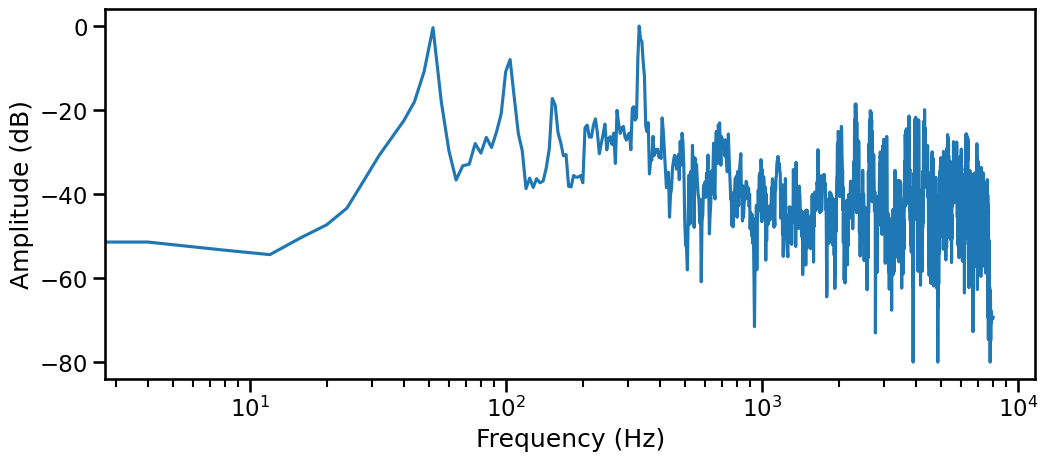

In [41]:
plt.figure().set_figwidth(12)
plt.plot(freq, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

To reduce the **spectral leakage** phenomenon (spreading of a signal's energy from its true frequency to neighboring frequencies in the spectrum) we will use a window function known as the **Hanning window**. This phenomenon can be caused by the abrupt beginning and end of the signal, or non-analysis frequencies.

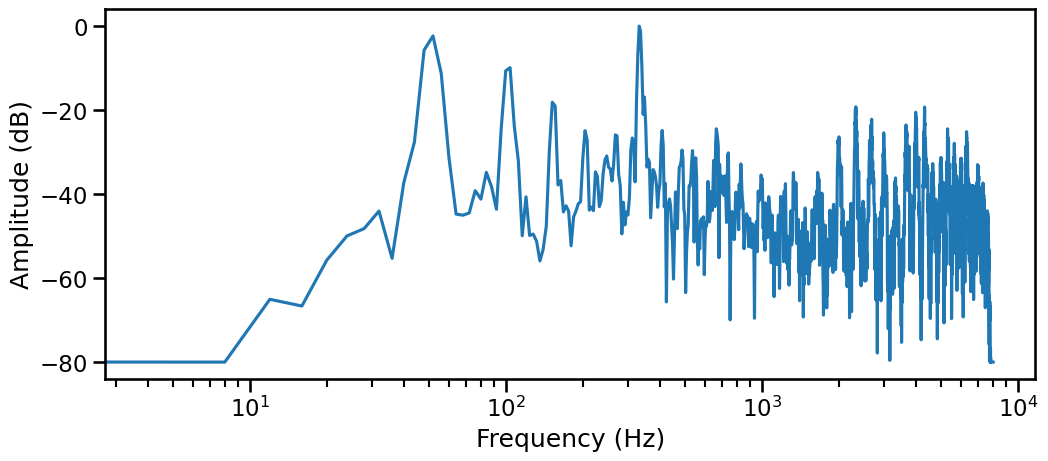

In [42]:
# Hanning window
window = np.hanning(len(samples))
windowed_input = samples * window

fft_result = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
mag = librosa.amplitude_to_db(np.abs(fft_result), ref=np.max)

# get the frequency bins
freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(samples))

plt.figure().set_figwidth(12)
plt.plot(freq, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

The frequency spectrum of an audio signal contains the exact same information as its waveform — they are simply two different ways of looking at the same data. Where the **waveform plots the amplitude of the audio signal over time, the spectrum visualizes the amplitudes of the individual frequencies at a fixed point in time**.

### **Spectogram**

A **Spectrogram** is a 2D plot that shows how the **frequency content of a signal changes over time**. It takes multiple DFTs, each covering only a small slice of time, and stack the resulting spectra together into the plot

It's a valuable tool for analyzing audio signals, especially for identifying patterns, frequencies, and time-varying characteristics.

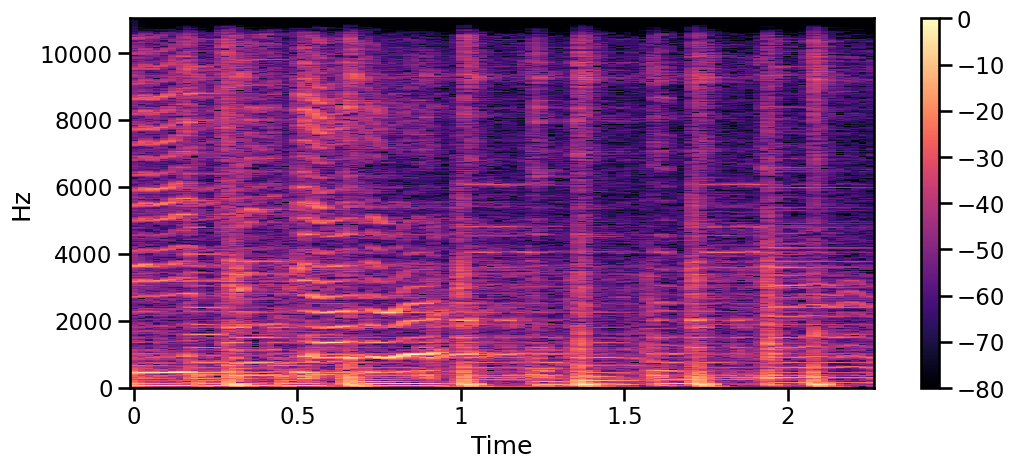

In [43]:
D = librosa.stft(array[:len(array)//2])
S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="hz")
plt.colorbar()

Each vertical slice in the spectogram corresponds to a single frequency spectrum, seen from the top. Where:

-   X-axis: Represents time, often in seconds.
-   Y-axis: Represents frequency, usually in Hertz (Hz).
-   Color/intensity: Represents the amplitude (dB) or intensity of the frequency component at a given time.

### **Mel Spectogram**

A *Mel spectrogram* is a modification of the traditional spectrogram that is designed to **better reflect human hearing** perception. Mel-scale frequencies are *based on a logarithmic scale that approximates how humans perceive pitch*. This makes mel spectrograms more suitable for tasks that involve human auditory perception, such as speech recognition and music analysis.

In order to create a mel spectogram the SFT is used as before, however, each spectrum is then sent through a set of filters (mel filterbank), to transform the frequencies to the mel scale.

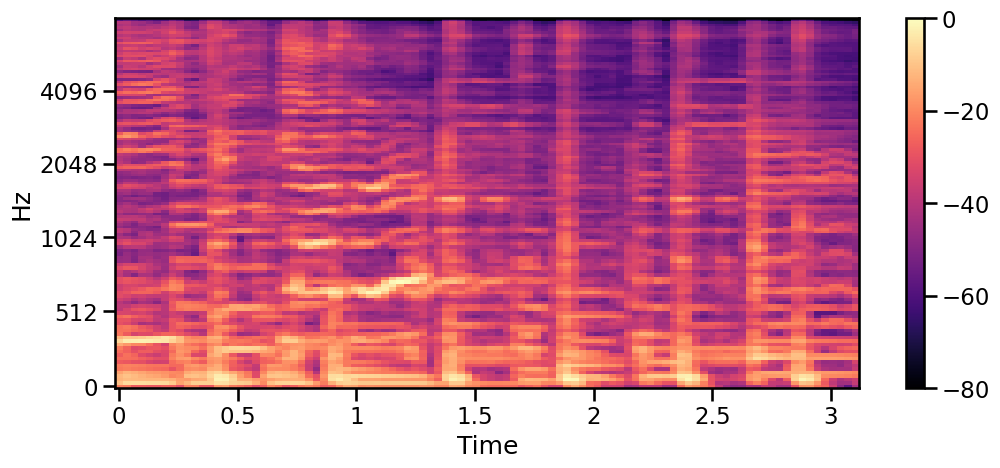

In [44]:
S = librosa.feature.melspectrogram(y=array[:len(array)//2], sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

In this mel spectrogram, the vertical stripes represent different notes or chords, and the horizontal bands indicate the frequency range in the mel scale.

## **Audio Features**

Every audio signal consists of many features. However, we must extract the characteristics that are relevant to the problem we are trying to solve. As a first approach we will extract as much features as possible and then use regularization techniques if needed to perform feature selection.

### **Zero Crossing Rate**

The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.

If we zoom enough in the Waveplot we will be able to manually count the zero crossing rate.

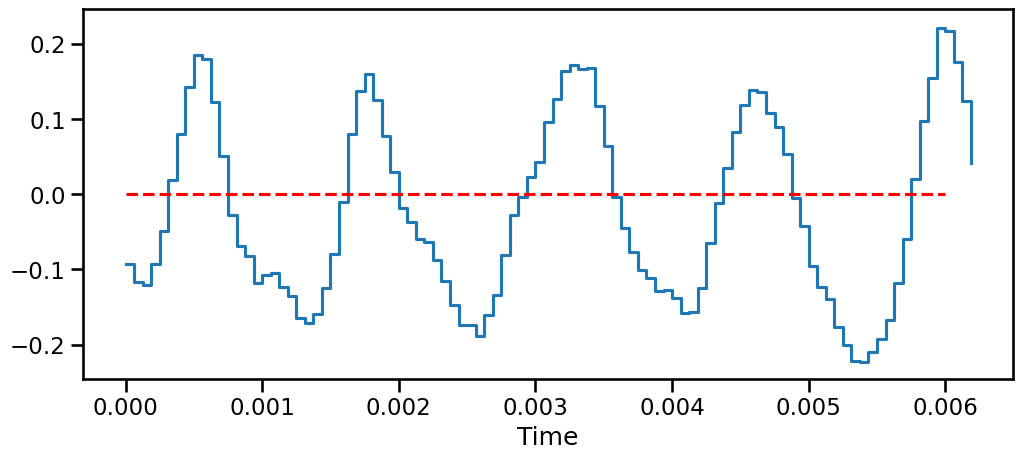

In [45]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(array[20000:20100], sr=sampling_rate)
plt.hlines(y=0, xmin=0, xmax=0.006, colors='r', linestyles='--')

We confirm with librosa the amount of zero crossings seen, 9 in total.

In [46]:
# Using librosa zero_crossings() function
zero_crossings = librosa.zero_crossings(array[20000:20100], pad=False)
print(sum(zero_crossings))

9


### **Spectral Centroid**

It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [47]:
spectral_centroids = librosa.feature.spectral_centroid(y=array, sr=sampling_rate)[0]
spectral_centroids.shape

(196,)

In order to visualize the spectral centroids we must first convert the frame count into time (s).

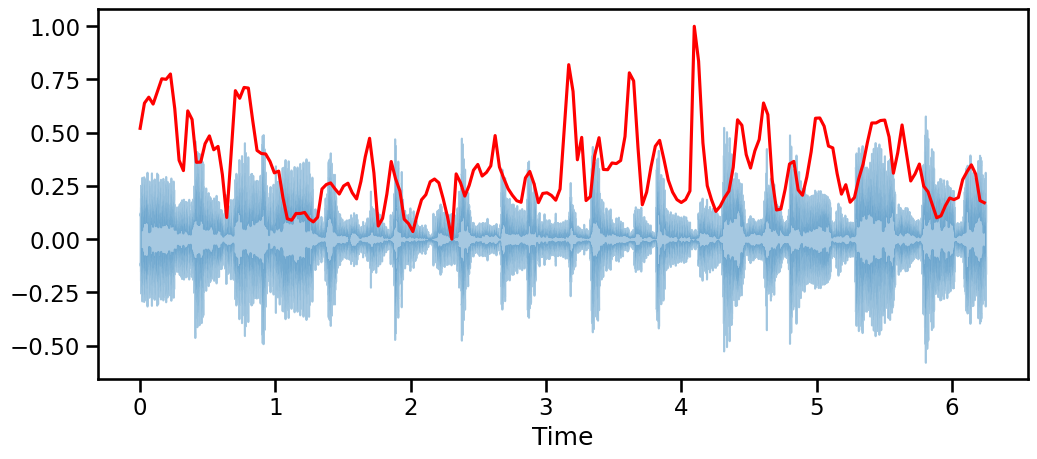

In [48]:
# Using librosa function frames_to_time()
frames = range(spectral_centroids.shape[0])
t = librosa.frames_to_time(frames, sr=sampling_rate)

# Normalize using min-max normalization for visualization
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Ploting the Spectral Centroid along with the Waveplot
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r');

We can see that the spectral centroid is quite uniform along most of the reggae song. This makes sense as this genre is characterized for being steady and having a repetitive drum pattern.

### **Spectral Rolloff**

**Spectral rolloff** is a feature that measures the *frequency below which a certain percentage of a signal's energy is concentrated*. It provides an indication of the overall spectral shape of the signal.

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least a `roll_percent` (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

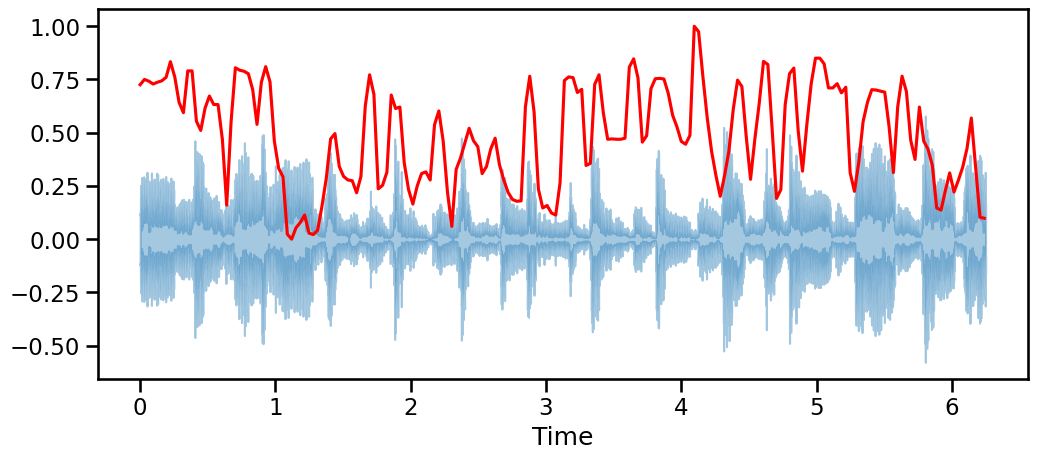

In [49]:
# Using the librosa spectral_rolloff() function
rolloff_def = librosa.feature.spectral_rolloff(y=array, sr=sampling_rate)[0]

# Displaying the Spectral Rolloff along with the Waveplot
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(rolloff_def), color='r');

As we are referring to the signal energy and frequency a spectrogram is a better tool to visualize the spectral rolloff of a signal.

In [50]:
# Approximate maximum frequencies with roll_percent=0.99
rolloff_max = librosa.feature.spectral_rolloff(y=array, sr=sampling_rate, roll_percent=0.99)[0]

# Approximate minimum frequencies with roll_percent=0.01
rolloff_min = librosa.feature.spectral_rolloff(y=array, sr=sampling_rate, roll_percent=0.01)[0]

# Spectogram to compare
S, phase = librosa.magphase(librosa.stft(array))
S_dB = librosa.amplitude_to_db(S, ref=np.max)

[Text(0.5, 1.0, 'log Power spectrogram')]

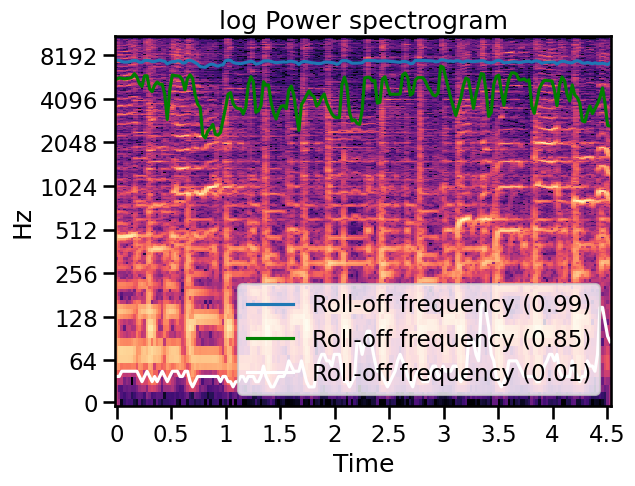

In [51]:
fig, ax = plt.subplots()
librosa.display.specshow(S_dB, y_axis='log', x_axis='time', ax=ax)

ax.plot(librosa.times_like(rolloff_max), rolloff_max, label='Roll-off frequency (0.99)')
ax.plot(librosa.times_like(rolloff_def), rolloff_def, color='g', label='Roll-off frequency (0.85)')
ax.plot(librosa.times_like(rolloff_min), rolloff_min, color='w', label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log Power spectrogram')

### **RMS**

The **Root Mean Square (RMS)** is a statistical measure that quantifies the amplitude of a signal. It provides a **measure of the overall energy or power of the signal**.

Librosa documentation gives us a good advice for calculating the RMS: Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using `S` if it’s already available.

$$ RMS = \sqrt{\frac{1}{N} \cdot \sum{x[n]^2}}$$

where:
- $N$ is the number of samples in the signal.
- $x[n]$ is the value of the signal at sample $n$.

In [52]:
rms = librosa.feature.rms(S=S)

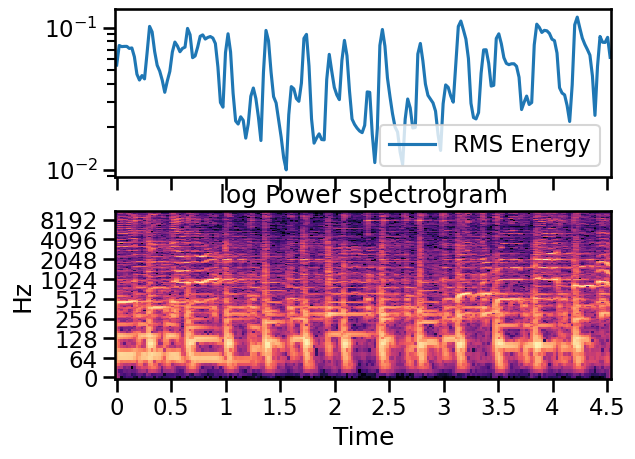

In [53]:
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram');

### **Mel-frequency cepstral coefficients (MFCCs)**

**MFCCs** are a feature extraction technique widely used in speech recognition, music information retrieval, and audio classification. They are designed to **capture the spectral envelope of a signal**, which is a representation of the overall frequency distribution.

In [54]:
# Recalculating the spectogram but in the log-power Mel Scale
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128,
                                   fmax=8000)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
mfccs.shape

(20, 196)

The `mfcc()` function returns a NumPy array of shape (n_mfcc, n_frames), where `n_mfcc` is the number of MFCC coefficients and `n_frames` is the number of frames in the STFT.

We can specify the number of MFCCs we want to adquire by specifying the `n_mfcc` parameter (delfaut 20).

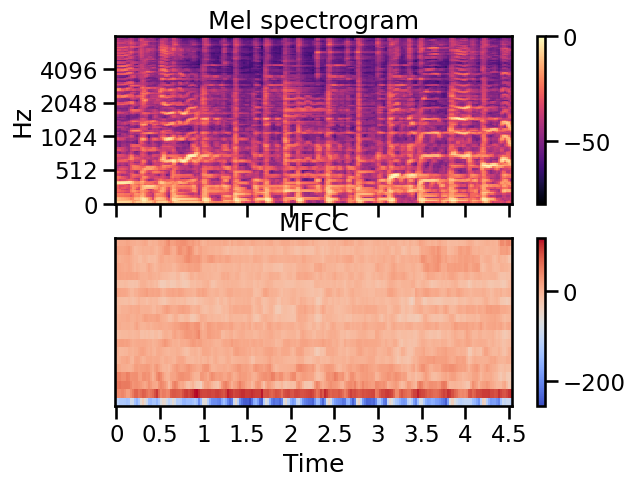

In [55]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC');

In a typical MFCC graph, the x-axis represents time, often measured in frames, while the y-axis represents the index of the MFCC coefficient. The color or intensity of each point on the graph indicates the magnitude of the corresponding MFCC coefficient at that specific time and index.

### **Chroma Frequencies**

**Chroma** features are a useful tool for analyzing the harmonic content of music signals. By projecting the entire frequency spectrum onto 12 bins, chroma features capture the essential information about the pitch relationships within a piece of music. They're a representation of the **similarity of a signal to the 12 pitch classes** in Western music theory.

Chroma features are calculated by first computing the frequency spectrum of a signal. Then, the frequency bins are mapped to the 12 pitch classes based on their proximity, and the magnitudes of components within each class are accumulated. This results in a representation of the signal's harmonic content.

In [56]:
# Using a power spectogram as base
S = np.abs(librosa.stft(y=array, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sampling_rate)

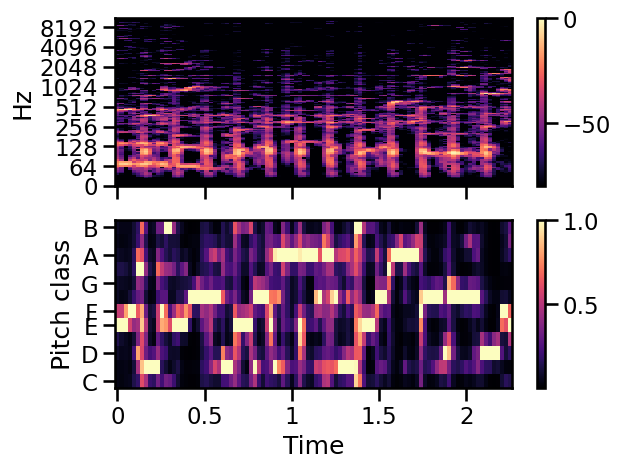

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

### **Spectral Bandwidth**

**Spectral bandwidth** is a measure of the **spread of a signal's energy in the frequency domain**. It indicates the range of frequencies that contribute significantly to the signal's content.

The spectral bandwidth 1 at frame t is computed by:

$$ (\sum_k S[k, t] * (freq[k, t] - centroid[t])^p)^{(1/p)}$$

In [58]:
# From a spectogram input

S, phase = librosa.magphase(librosa.stft(y=array))
spec_bw = librosa.feature.spectral_bandwidth(S=S)

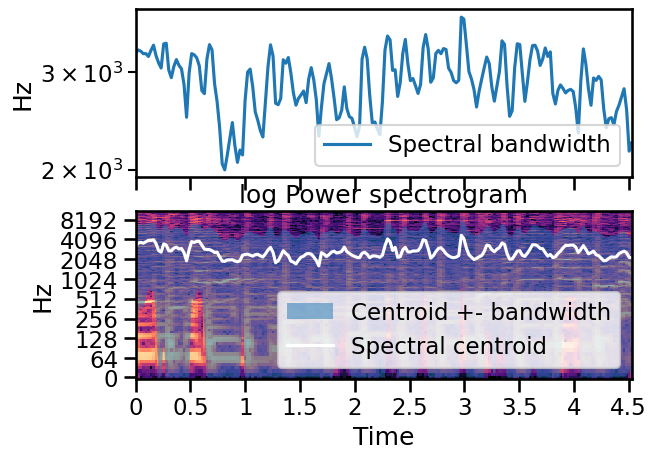

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sampling_rate/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

In the image we can see the magnitude of the bandwidth and how it changes along the song. However, for better understanding and visualization it is also represented along the spectogram as the blue area.

### **Spectral Contrast**

**Spectral contrast** is a feature that measures the difference between the highest and lowest peaks in the spectrum of a signal. It provides an **indication of the overall spectral variability of the signal**, in other words, how the energy of the signal is changing over time.

Each frame of a spectrogram S is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise. [Librosa]

In [60]:
S = np.abs(librosa.stft(y=array))
contrast = librosa.feature.spectral_contrast(S=S, sr=sampling_rate)

[Text(0, 0.5, 'Frequency bands'), Text(0.5, 1.0, 'Spectral contrast')]

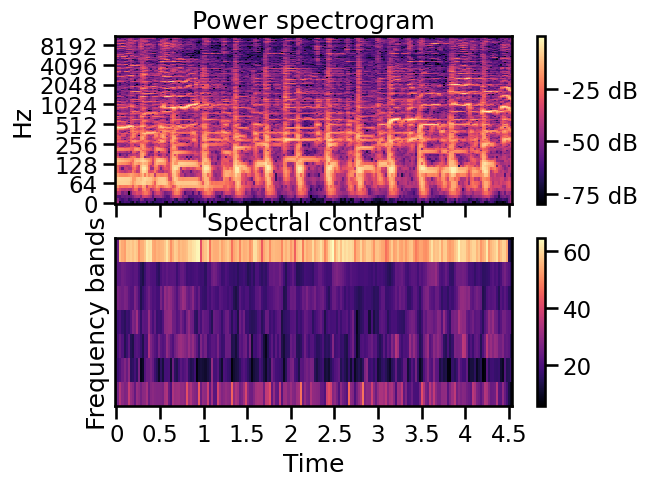

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img1, ax=[ax[0]], format='%+2.0f dB')
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
img2 = librosa.display.specshow(contrast, x_axis='time', ax=ax[1])
fig.colorbar(img2, ax=[ax[1]])
ax[1].set(ylabel='Frequency bands', title='Spectral contrast')

### **Tonnal Centroid Features (Tonnetz)**

**Tonal centroid features**, also known as tonnetz features, are a representation of the harmonic content of a musical signal based on the tonal relationships between notes in Western music theory.

Chroma features focus on the relative strength of individual pitch classes, while *tonal centroid features* focus on the **overall tonal center or key of the music**. They represent the tonal relationships between different pitch classes and are often used to identify the key of a piece of music or analyze the tonal structure of a chord progression.

In [62]:
tonnetz = librosa.feature.tonnetz(y=array, sr=sampling_rate)

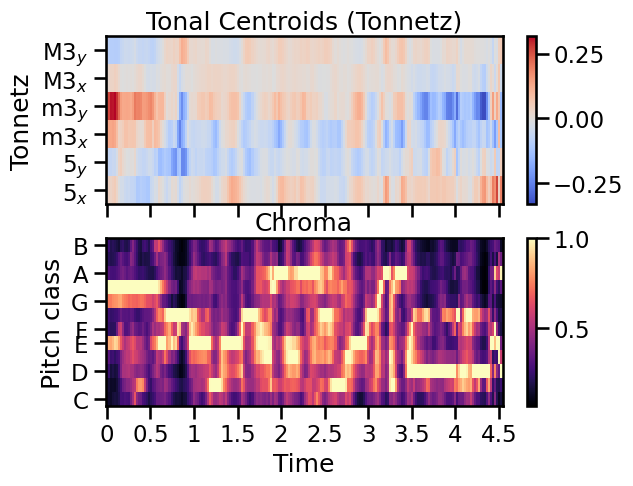

In [63]:
# Compare the tonnetz features to chroma_cqt
fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax[0])
ax[0].set(title='Tonal Centroids (Tonnetz)')
ax[0].label_outer()
img2 = librosa.display.specshow(librosa.feature.chroma_cqt(y=array, sr=sampling_rate),
                                y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chroma')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

This representation projects chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two-dimensional coordinates.